## 11 July 2018
-- Laurin Gray

We have data on which points appear to the right of the 3 sigma line, organized by the number of CMDs that they were flagged in.  We are still determining how many CMDs a source should appear in to be considered a red candidate.  This notebook overplots the points that appear in all 10 CMDs on some of the CMDs, to see if there is a pattern in where they appear.

The sources come from the catalog of Spitzer sources of Khan et al. (2015), matched with sources from Whitelock et al. (2013) in CasJobs.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde
import csv
import pathlib

In [2]:
# Read in my data from a .csv file saved locally.

# all sources
phot_data = pd.read_csv('~/Documents/Phot_data/CMDparameters26June2018_lauringray.csv')

# CMD counts
CMD_counts = pd.read_csv('/Users/lgray/Documents/Phot_data/CMD_counting_11July2018_lauringray.csv')

In [3]:
# Create all color cuts needed for plotting

phot_data['threesixMINUSeightzero'] = phot_data.k36mag.values - phot_data.k80mag.values
#
phot_data['fourfiveMINUSeightzero'] = phot_data.k45mag.values - phot_data.k80mag.values
#
phot_data['hMINUSthreesix'] = phot_data.Hmag.values - phot_data.k36mag.values
phot_data['hMINUSfourfive'] = phot_data.Hmag.values - phot_data.k45mag.values
#
phot_data['kMINUSthreesix'] = phot_data.Kmag.values - phot_data.k36mag.values
phot_data['kMINUSfourfive'] = phot_data.Kmag.values - phot_data.k45mag.values

In [4]:
# Some values in the tables are +/- 9999, due to null data from combining the tables, 
# which throws off the color scaling.  We wish to exclude these values, 
# which we do by cutting to only include values in the range -500:500

filter_phot_data = phot_data[(phot_data < 500.0) & (phot_data > -500.0)]

In [5]:
# For ease in calling functions, we rename all the value arrays to exclude filter_phot_data._____.values
# Because there's so many, I'm only defining ones I'll probably need- I can add any later

# Magnitudes
eightzero = filter_phot_data.k80mag.values
Hmag = filter_phot_data.Hmag.values
Kmag = filter_phot_data.Kmag.values


# Colors
threesixMINUSeightzero = filter_phot_data.threesixMINUSeightzero.values

fourfiveMINUSeightzero = filter_phot_data.fourfiveMINUSeightzero.values

jMINUSh = filter_phot_data.jMINUSh.values
jMINUSk = filter_phot_data.jMINUSk.values

hMINUSthreesix = filter_phot_data.hMINUSthreesix.values
hMINUSfourfive = filter_phot_data.hMINUSfourfive.values
hMINUSk = filter_phot_data.hMINUSk.values

kMINUSthreesix = filter_phot_data.kMINUSthreesix.values
kMINUSfourfive = filter_phot_data.kMINUSfourfive.values

# CMD counts
in_one = CMD_counts.in_one.values
in_two = CMD_counts.in_two.values
in_three = CMD_counts.in_three.values
in_four = CMD_counts.in_four.values
in_five = CMD_counts.in_five.values
in_six = CMD_counts.in_six.values
in_seven = CMD_counts.in_seven.values
in_eight = CMD_counts.in_eight.values
in_nine = CMD_counts.in_nine.values
in_ten = CMD_counts.in_ten.values

rows = phot_data.ID.values

In [6]:
def corr_rows(groups, lengths):
    """
    Some of the ID numbers are wrong (ex. there are two 2118s), which means we can't use the ID to 
    directly access the row it belongs to. As we go further down, the problem gets worse.
    This function finds the correct rows in phot_data for each ID and saves them to a list.

    Takes a list of the CMD counts you want to include in the plot (group) (and their corresponding lengths) 
    and outputs a list of the rows in phot_data which correspond to the IDs in those groups.
    
    """
    
    phot_rows = []
    
    #k = 0
    d = 0
    for j in groups:
        group_lim = lengths[d]
        k = 0
        #print(group_lim)
        for i in j:
            c = 0 # counter for phot_data rows, resets for each new element i
            # use a while loop so that it iterates until the end of the column
            while c < 30761 and k < group_lim: # to prevent reaching the end of the column and getting a nan error
                if int(i) != rows[c]: # check if i is equivalent to the ID in the current phot_data row
                    c = c+1 # if not, move to next row & go back to the top of the while loop
                else: # if i IS equivalent
                    phot_rows.append(c) # add the current row to corr_rows
                    c = 30761 # set c to stop iterating through the rest of the rows (end loop)
            k = k+1 # symbolically move onto the next element in in_ten (to stop the while loop at the end of in_ten)
        
        d = d+1
    
    return phot_rows

In [7]:
# Access the x and y values of each source by looking up their ID in phot_data

def coord_lookup(xaxis, yaxis, source_rows):
    """
    Takes the row of a source in the CMD count, then uses it to look up the x and y values in the phot_data table.
    source_rows should come from the output of the corr_rows function.
    
    Call example:
        x_flag, y_flag = coord_lookup(threesixMINUSeightzero, eightzero, source_rows)
    """
    
    x_vals = []
    y_vals = []
    k = 0 # row counter
    for i in source_rows:
        x_vals.append(xaxis[i])
        y_vals.append(yaxis[i])
    
    return x_vals, y_vals

In [8]:
def plot_CMD(xaxis, yaxis, x_flagged, y_flagged):
    """
    Plot a CMD, and overplot the values that are flagged in all 10 CMDs.
    """
    
    # set axis limits & names (so I don't have to do it manually each time I plot)
    if yaxis is eightzero:
        y1 = 8.0
        y2 = 18.0
        ylabel = '[8.0]'
    elif yaxis is Hmag:
        y1 = 11.5
        y2 = 19.0
        ylabel = 'H'
    elif yaxis is Kmag:
        y1 = 11.5
        y2 = 19.0
        ylabel = 'K'
    
    if xaxis is threesixMINUSeightzero:
        x1 = -2.0
        x2 = 7.5
        xlabel = '[3.6] - [8.0]'
    elif xaxis is fourfiveMINUSeightzero:
        x1 = -1.5
        x2 = 6.5
        xlabel = '[4.5] - [8.0]'
    elif xaxis is jMINUSh:
        x1 = -0.5
        x2 = 2.5
        xlabel = 'J - H'
    elif xaxis is hMINUSk:
        x1 = -0.5
        x2 = 2.0
        xlabel = 'H - K'
    elif xaxis is hMINUSthreesix:
        x1 = -1.5
        x2 = 4.0
        xlabel = 'H - [3.6]'
    elif xaxis is hMINUSfourfive:
        x1 = -2.5
        x2 = 5.0
        xlabel = 'H - [4.5]'
    elif xaxis is jMINUSk:
        x1 = -0.5
        x2 = 4.0
        xlabel = 'J - K'
    elif xaxis is kMINUSthreesix:
        x1 = -2.0
        x2 = 3.5
        xlabel = 'K - [3.6]'
    elif xaxis is kMINUSfourfive:
        x1 = -2.5
        x2 = 3.5
        xlabel = 'K - [4.5]'
    
    plt.figure(figsize=(10,10))
    plt.plot(xaxis,yaxis,',')
    plt.xlim(x1, x2)
    plt.ylim(y2, y1)
    plt.xlabel(xlabel, size=12)
    plt.ylabel(ylabel, size=12)
    plt.scatter(x_flagged, y_flagged, c='red', s=1)

For reference:
- in_one: 667
- in_two: 2402
- in_three: 266
- in_four: 219
- in_five: 113
- in_six: 101
- in_seven: 65
- in_eight: 177
- in_nine: 107
- in_ten: 152

The following plots are only for sources that were flagged in all 10 CMDs

In [9]:
cols = [in_ten]
col_len = [152]

source_rows = corr_rows(cols, col_len)

In [10]:
#print(source_rows)
# confirm that all 152 of the points in in_ten were iterated
#print("there are", len(source_rows), "points of interest (152 for in_ten, 259 for in_ten & in_nine)")
# if I want the first ID in in_ten (106), then I should access row 105 of phot_data
#print("row 105 has ID", rows[105], "(106)")
# and to check that the last ID (4037) also matches, I should access row 4046 of phot_data
#print("row 4046 has ID", rows[4046], "(4037)")

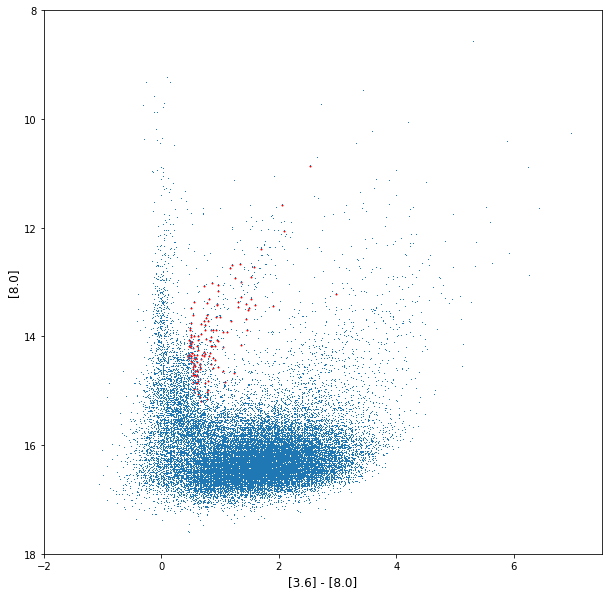

In [11]:
# [8.0] vs. [3.6] - [8.0]

xaxis = threesixMINUSeightzero
yaxis = eightzero

x_flag, y_flag = coord_lookup(xaxis, yaxis, source_rows)

plot_CMD(xaxis, yaxis, x_flag, y_flag)

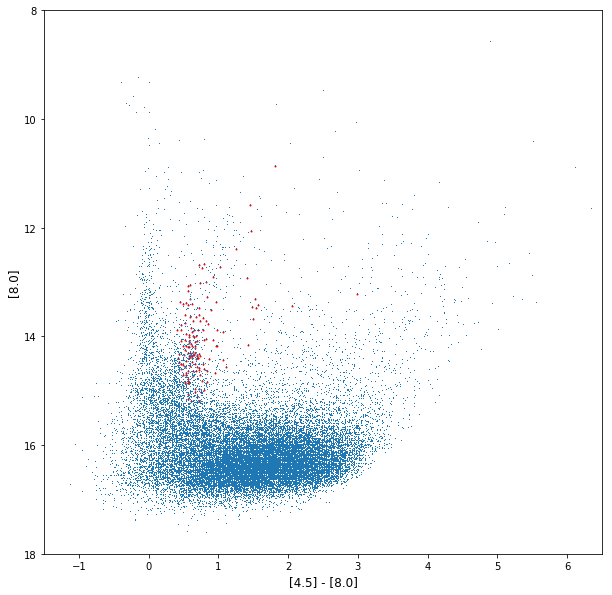

In [12]:
# [8.0] vs. [4.5] - [8.0]

xaxis = fourfiveMINUSeightzero
yaxis = eightzero

x_flag, y_flag = coord_lookup(xaxis, yaxis, source_rows)

plot_CMD(xaxis, yaxis, x_flag, y_flag)

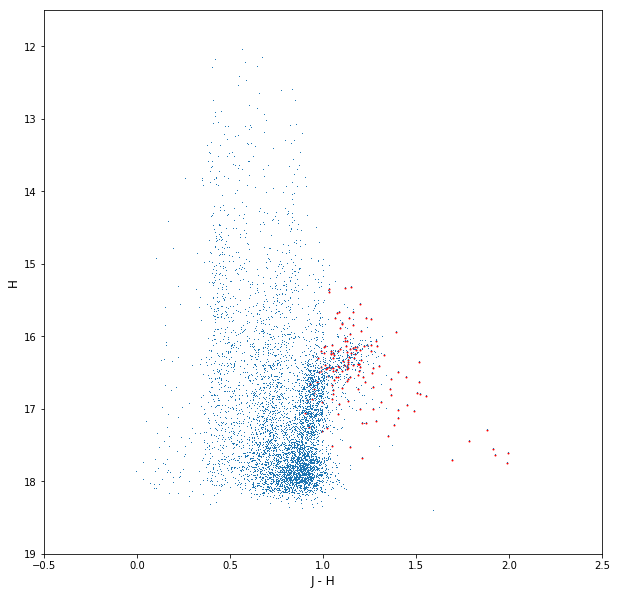

In [13]:
# H vs. J - H

xaxis = jMINUSh
yaxis = Hmag

x_flag, y_flag = coord_lookup(xaxis, yaxis, source_rows)

plot_CMD(xaxis, yaxis, x_flag, y_flag)

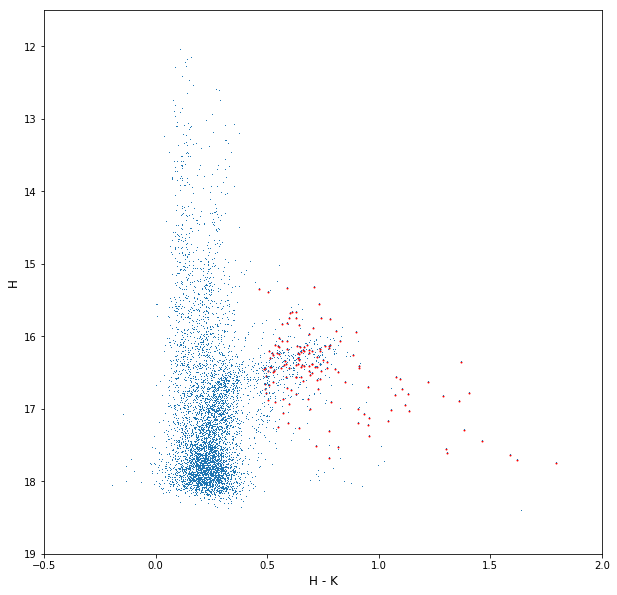

In [14]:
# H vs. H - K

xaxis = hMINUSk
yaxis = Hmag

x_flag, y_flag = coord_lookup(xaxis, yaxis, source_rows)

plot_CMD(xaxis, yaxis, x_flag, y_flag)

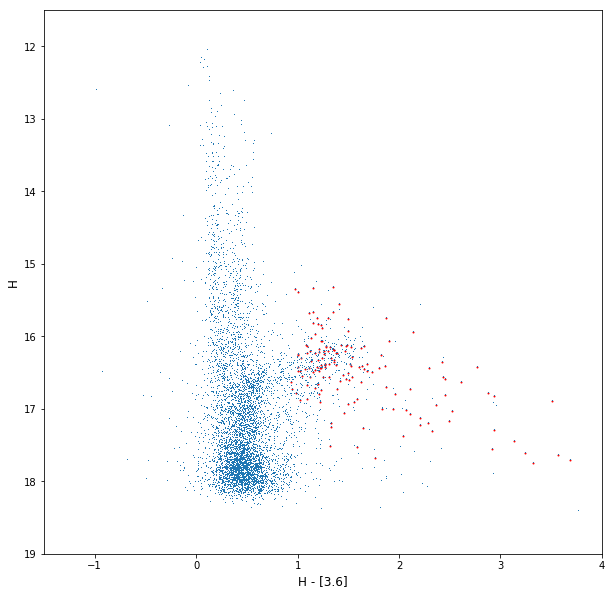

In [15]:
# H vs. H - [3.6]

xaxis = hMINUSthreesix
yaxis = Hmag

x_flag, y_flag = coord_lookup(xaxis, yaxis, source_rows)

plot_CMD(xaxis, yaxis, x_flag, y_flag)

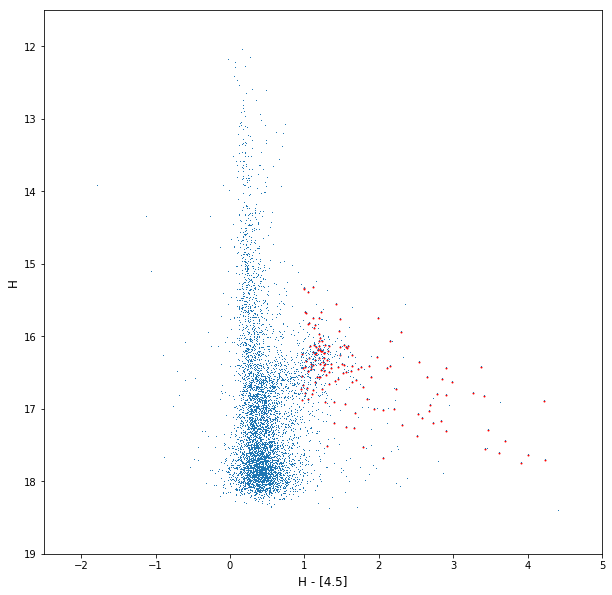

In [16]:
# H vs. H - [4.5]

xaxis = hMINUSfourfive
yaxis = Hmag

x_flag, y_flag = coord_lookup(xaxis, yaxis, source_rows)

plot_CMD(xaxis, yaxis, x_flag, y_flag)

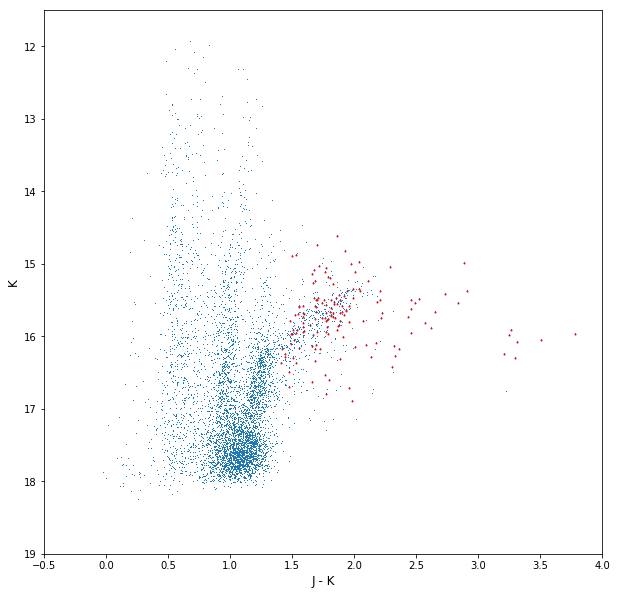

In [17]:
# K vs. J - K

xaxis = jMINUSk
yaxis = Kmag

x_flag, y_flag = coord_lookup(xaxis, yaxis, source_rows)

plot_CMD(xaxis, yaxis, x_flag, y_flag)

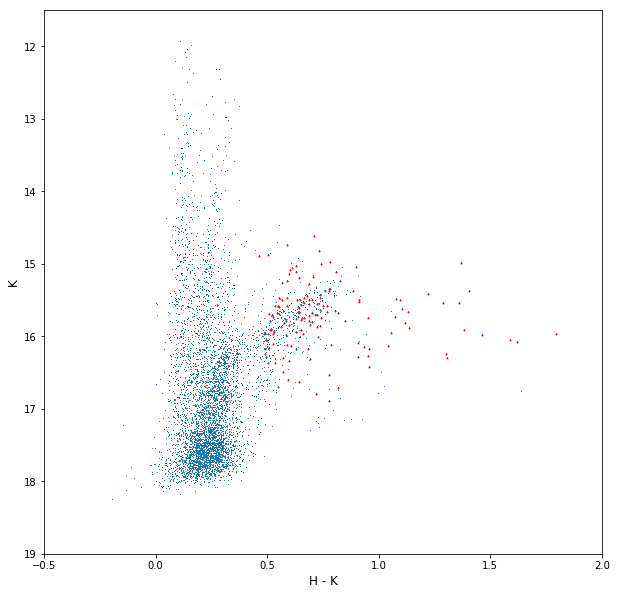

In [18]:
# K vs. H - K

xaxis = hMINUSk
yaxis = Kmag

x_flag, y_flag = coord_lookup(xaxis, yaxis, source_rows)

plot_CMD(xaxis, yaxis, x_flag, y_flag)

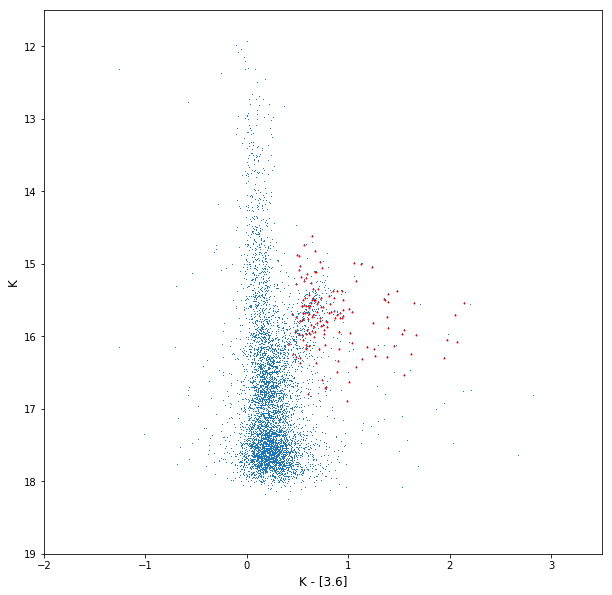

In [19]:
# K vs. K - [3.6]

xaxis = kMINUSthreesix
yaxis = Kmag

x_flag, y_flag = coord_lookup(xaxis, yaxis, source_rows)

plot_CMD(xaxis, yaxis, x_flag, y_flag)

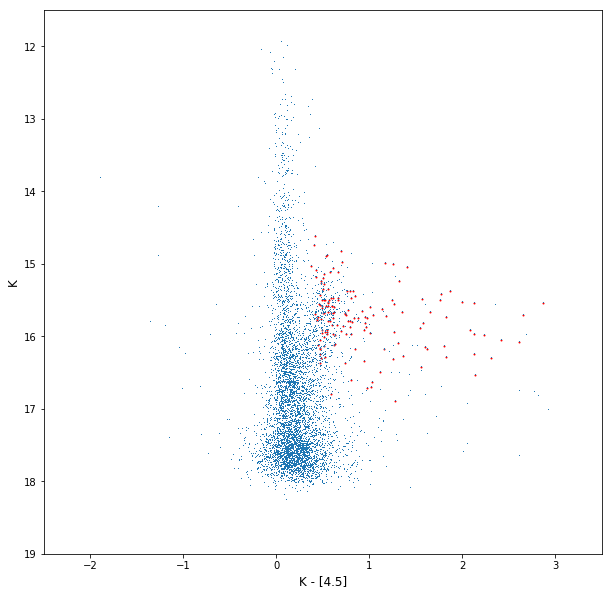

In [20]:
# K vs. K - [4.5]

xaxis = kMINUSfourfive
yaxis = Kmag

x_flag, y_flag = coord_lookup(xaxis, yaxis, source_rows)

plot_CMD(xaxis, yaxis, x_flag, y_flag)